In [ ]:
from importlib.metadata import version
version('gensim')

### Extract and Preprocess Text Data

In [1]:
import nltk
import re
import numpy as np
import pandas as pd
from pprint import pprint
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Import Dataset
df = pd.read_csv("data-bersihLDA-positif.csv")
stop=set(stopwords.words("indonesian"))
stop_bow = set(stopwords.words("indonesian"))
stop_bow.discard("tidak")
factory = StemmerFactory()
stemmer = factory.create_stemmer()

text=df["tweet"]
cleaned_text_bow=[]
cleaned_text=[]
for line in text:
    tags = re.compile("^@[a-zA-Z_]*")
    line = re.sub(tags," ",line)
    hashtags = re.compile("#|\*")
    extraCharacters = re.compile("[^a-zA-Z]")
    line = re.sub(extraCharacters," ",line)

    filtered_words=[]
    filtered_words_bow=""
    for word in line.split():
        word=word.lower()
        if(word not in stop):
            word = stemmer.stem(word)
            filtered_words.append(word)
        if(word not in stop_bow):
            word = stemmer.stem(word)
            filtered_words_bow+=" "+word
    cleaned_text.append(filtered_words)
    cleaned_text_bow.append(filtered_words_bow)
            
data_bow = pd.DataFrame(data=cleaned_text_bow,columns=["tweet"])
data_bow["label"] = df["label"]
df["tweet"]=cleaned_text
print(df.head(10))
print()
print(data_bow.head(10))
print()


   Unnamed: 0                                              tweet    label
0           0  [asli, kampus, merdeka, seru, seru, ikut, satu...  positif
1           1  [merdeka, ajar, kampus, merdeka, ubah, ubah, h...  positif
2           2  [aduh, enak, banget, mahasiswa, kampus, merdek...  positif
3           3  [syukur, reformasi, birokrasi, sistem, akredit...  positif
4           4  [correct, me, if, am, wrong, tugas, atur, ada,...  positif
5           5  [senang, kampus, terap, bijak, kampus, merdeka...  positif
6           6  [heran, pikir, tuju, nadiem, menteri, didik, l...  positif
7           7  [nadiem, gojek, penting, gojek, pikir, didik, ...  positif
8           8  [pakai, kampus, merdeka, dobrak, moga, hasil, ...  positif
9           9  [mantap, banget, usaha, buka, magang, kolabora...  positif

                                               tweet    label
0   asli kampus merdeka seru seru sayang semester...  positif
1   merdeka ajar kampus merdeka ubah ubah harap k...  positif

In [4]:
# Create Dictionary
id2word = corpora.Dictionary(df["tweet"])

# Create Corpus
texts = cleaned_text

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 3), (13, 2)]]


In [385]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ambil', 1),
  ('asli', 1),
  ('banget', 1),
  ('ikut', 1),
  ('juang', 1),
  ('kampus', 1),
  ('magang', 1),
  ('merdeka', 1),
  ('muda', 1),
  ('pas', 1),
  ('satu', 1),
  ('sayang', 1),
  ('semester', 3),
  ('seru', 2)]]

In [5]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.1, eta=0.1,
                                           per_word_topics=True)

In [6]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=cleaned_text, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.162951643729217

Coherence Score:  0.42247746417420473


In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

In [7]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.1, eta=0.1,
                                           per_word_topics=True)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [8]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=cleaned_text, start=2, limit=100, step=3)

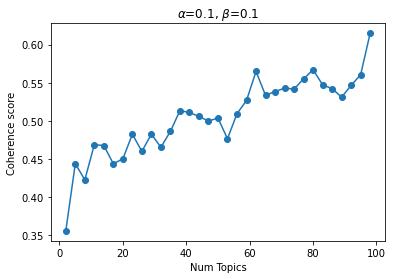

In [9]:
# Show graph
limit=100; start=2; step=3;
x = range(start, limit, step)
eq = r"$\alpha$=0.1, $\beta$=0.1"
plt.title(eq) 
plt.plot(x, coherence_values, '-o')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [10]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 5))

Num Topics = 2  has Coherence Value of 0.35549
Num Topics = 5  has Coherence Value of 0.44375
Num Topics = 8  has Coherence Value of 0.42248
Num Topics = 11  has Coherence Value of 0.4687
Num Topics = 14  has Coherence Value of 0.46749
Num Topics = 17  has Coherence Value of 0.44357
Num Topics = 20  has Coherence Value of 0.45015
Num Topics = 23  has Coherence Value of 0.48226
Num Topics = 26  has Coherence Value of 0.45992
Num Topics = 29  has Coherence Value of 0.48247
Num Topics = 32  has Coherence Value of 0.46523
Num Topics = 35  has Coherence Value of 0.48612
Num Topics = 38  has Coherence Value of 0.51333
Num Topics = 41  has Coherence Value of 0.51091
Num Topics = 44  has Coherence Value of 0.50568
Num Topics = 47  has Coherence Value of 0.49975
Num Topics = 50  has Coherence Value of 0.50349
Num Topics = 53  has Coherence Value of 0.47646
Num Topics = 56  has Coherence Value of 0.50932
Num Topics = 59  has Coherence Value of 0.52665
Num Topics = 62  has Coherence Value of 0.56

In [12]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=5))

[(0,
  '0.085*"kampus" + 0.084*"merdeka" + 0.045*"tertawa" + 0.038*"saku" + '
  '0.037*"magang"'),
 (1,
  '0.042*"merdeka" + 0.041*"kampus" + 0.027*"dosen" + 0.026*"akademik" + '
  '0.023*"lambat"'),
 (2,
  '0.153*"merdeka" + 0.144*"kampus" + 0.039*"mahasiswa" + 0.038*"uang" + '
  '0.020*"ribet"'),
 (3,
  '0.042*"anak" + 0.020*"mendikbud" + 0.018*"web" + 0.017*"stres" + '
  '0.017*"ilmu"'),
 (4,
  '0.093*"merdeka" + 0.085*"kampus" + 0.043*"mahasiswa" + 0.026*"magang" + '
  '0.023*"kuliah"')]


In [374]:
optimal_model.alpha

array([0.15284023, 0.11924951, 0.12809134, 0.12722345, 0.22118625,
       0.36014387, 0.12444338, 1.5271426 ], dtype=float32)

In [13]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

c:\Users\HP\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.180814 -0.024407       1        1  46.346609
4     -0.142255 -0.061700       2        1  22.805063
0     -0.075786  0.209961       3        1  17.733600
1      0.085960 -0.182762       4        1   6.734564
3      0.312894  0.058908       5        1   6.380164, topic_info=             Term        Freq       Total Category  logprob  loglift
111       tertawa   55.000000   55.000000  Default  30.0000  30.0000
386          uang  121.000000  121.000000  Default  29.0000  29.0000
6          magang   87.000000   87.000000  Default  28.0000  28.0000
109          gara   44.000000   44.000000  Default  27.0000  27.0000
686          saku  108.000000  108.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1418    korporasi    3.215038    3.569042   Topic5  -4.9221   2.6475
1417  kontributor    3.215038    3.569042   Topic5  -4.9221   2.6475
1416          ana    3.215038    3.569042   Topic5  -4.9221   2.6475
53          didik    3.874424   29.429930   Topic5  -4.7355   0.7244
686          saku    3.417547  108.407977   Topic5  -4.8610  -0.7050

[228 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
14        1  0.684539        ajar
14        2  0.308043        ajar
231       4  0.963664    akademik
33        5  0.972022  akreditasi
1425      4  0.820690    alangkah
...     ...       ...         ...
101       2  0.121114       usaha
101       3  0.847797       usaha
705       3  0.996525      vokasi
1001      5  0.978211         web
1426      4  0.820690       wujud

[211 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 2, 4])